<a href="https://colab.research.google.com/github/noahmarvisi/coral-detector/blob/main/notebooks/Detectron2_CoralReef_quadrat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.10.0+cu111 torchvision==0.11.1+cu111 torchaudio===0.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

import torch

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 34.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ec26f100abdb1ee2846aac8f8c6002695b8f1b1b3531b70a6f05469366bbae34
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
     |████████████▌                   | 834.1 MB 1.2 MB/s eta 0:17:34tcmalloc: large alloc 1147494400 bytes == 0x3a136000 @  0x7f055c294615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fc

torch:  1.10 ; cuda:  cu111


In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

# import mlflow
import mlflow

     |████████████████████████████████| 17.8 MB 26.8 MB/s 
     |████████████████████████████████| 181 kB 65.1 MB/s 
     |████████████████████████████████| 146 kB 89.9 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 209 kB 98.5 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 745 kB 32.6 MB/s 


# Import

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import copy
from google.colab.patches import cv2_imshow
from google.colab import files
import shutil
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, GenericMask

import torch

# Prepare dataset

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Define data path

In [1]:
base = '/content/drive/MyDrive/DSTI/coral_reef/img_equ'

## Parse the data and prepare it into detectron2's standard format

In [ ]:
def get_dataset_dicts(img_dir):
    dataset_dicts = []
    img_dir = Path(img_dir)
    for i, jsonpath in enumerate([*img_dir.glob("*.d2json")]):
      with open(str(jsonpath), 'r') as fp:
        head_tail = os.path.split(str(jsonpath))
        annot = json.load(fp)
        annot['image_id'] = i
        #print(Path(head_tail[1][:-7]+'.jpg'))
        assert not head_tail[1][:-7].endswith('(1)'), f"{head_tail}"
        annot['file_name'] = str(img_dir/Path(head_tail[1][:-7]+'.jpg'))
        
        dataset_dicts.append(annot)
    
    return dataset_dicts

In [ ]:
for d in ["training", "testing"]:
    DatasetCatalog.register("dataset_" + d, lambda d=d: get_dataset_dicts(f"{base}/{d}"))
    MetadataCatalog.get("dataset_" + d).set(thing_classes=['quadrat'])

dataset_metadata = MetadataCatalog.get("dataset_training")

In [ ]:
# Get dataset dicts
dataset_dicts = get_dataset_dicts(os.path.join(base, 'training'))
dataset_dicts_test = get_dataset_dicts(os.path.join(base, 'testing'))

In [ ]:
# Training set size
print('Training set size: ', len(dataset_dicts))
# Testing set size
print('Testing set size: ', len(dataset_dicts_test))

Training set size:  1035
Testing set size:  258


## Verify that the data is correctly loaded

https://detectron2.readthedocs.io/en/latest/_modules/detectron2/utils/visualizer.html

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import _create_text_labels
from detectron2.structures import BoxMode

In [ ]:
# Custom Visualizer class
class Visualizer_custom(Visualizer):
  def __init__(self, img_rgb, metadata=None, scale=1.0, instance_mode=ColorMode.SEGMENTATION):
    super().__init__(img_rgb, metadata, scale, instance_mode)

  def draw_dataset_dict(self, dic):
    """
    Draw annotations/segmentaions in Detectron2 Dataset format.

    Args:
      dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.

    Returns:
      output (VisImage): image object with visualizations.
    """
    annos = dic.get("annotations", None)
    if annos:
      
      if "segmentation" in annos[0]:
        masks = [x["segmentation"] for x in annos]
      else:
        masks = None
      if "keypoints" in annos[0]:
        keypts = [x["keypoints"] for x in annos]
        keypts = np.array(keypts).reshape(len(annos), -1, 3)
      else:
        keypts = None

      boxes = [
        BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS)
        if len(x["bbox"]) == 4
        else x["bbox"]
        for x in annos]

      colors = None
      category_ids = [x["category_id"] for x in annos]
      if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
        colors = [
            [x / 255 for x in self.metadata.thing_colors[c]]
            for c in category_ids]

      names = self.metadata.get("thing_classes", None)
      labels = _create_text_labels(
                category_ids,
                scores=None,
                class_names=names,
                is_crowd=[x.get("iscrowd", 0) for x in annos],
      )
      
      self.overlay_instances(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
      )

    return self.output

In [ ]:
# Choose the color here
MetadataCatalog.get("dataset_training").thing_colors = [(255,0,0)]
dataset_metadata = MetadataCatalog.get("dataset_training")

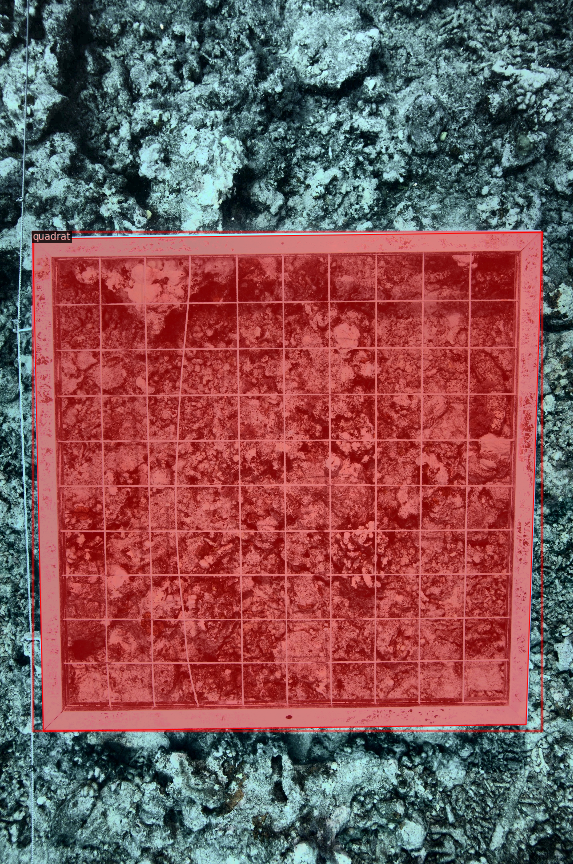

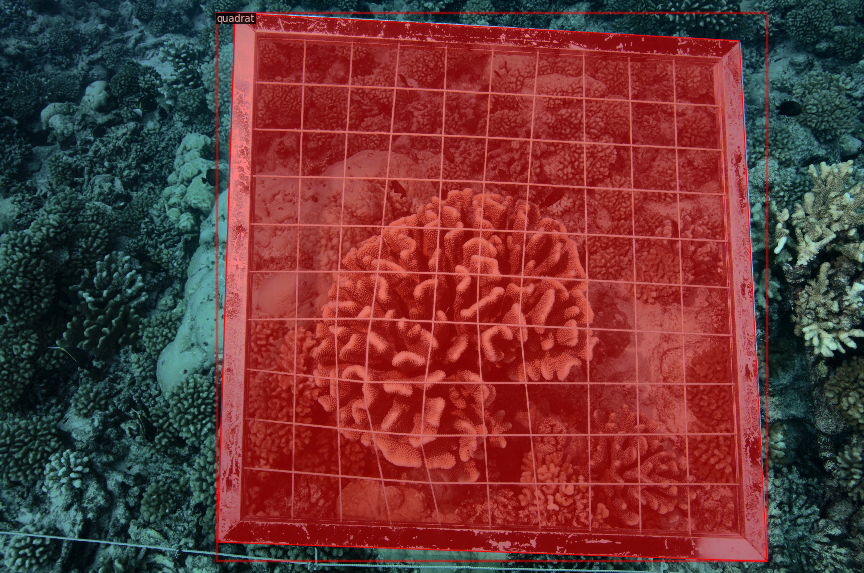

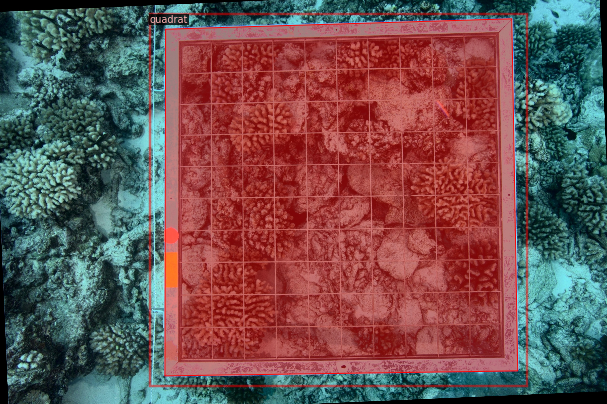

In [ ]:
# let's visualize the annotations of randomly selected samples in the training set
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer_custom(img[:, :, ::-1], 
                                  metadata=dataset_metadata,
                                  instance_mode=ColorMode.SEGMENTATION, 
                                  scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Training

## Custom config


Model zoo:

https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

Taming hyperparameters:

https://detectron2.readthedocs.io/en/latest/modules/config.html

https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#update-the-config-for-new-datasets

https://medium.com/analytics-vidhya/taming-the-hyper-parameters-of-mask-rcnn-3742cb3f0e1b

In [ ]:
def custom_config(model_path = None, BATCH_SIZE_PER_IMAGE = 512, BASE_LR = 0.005, MAX_ITER = 1000):

  cfg = get_cfg()

  # get configuration from model_zoo
  config_file = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
  cfg.merge_from_file(model_zoo.get_config_file(config_file))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # initialize weights from model zoo

  if model_path:
    assert os.path.isfile(model_path), 'file_path does not exist'
    cfg.MODEL.WEIGHTS = model_path
    #cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  

  # define datasets
  cfg.DATASETS.TRAIN = ("dataset_training",)
  cfg.DATASETS.VAL = ("dataset_testing",)
  cfg.DATASETS.TEST = ("dataset_testing",)

  # dataloader
  cfg.DATALOADER.NUM_WORKERS = 2

  # model
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE   # batch size
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (quadrat). 

  # solver
  cfg.SOLVER.IMS_PER_BATCH = 2  # images per batch
  cfg.SOLVER.BASE_LR = BASE_LR  # learning rate
  cfg.SOLVER.MAX_ITER = MAX_ITER    # 1000 iterations
  cfg.SOLVER.STEPS = []        # do not decay learning rate

  # testing
  #cfg.TEST.EVAL_PERIOD = 50
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
  
  # make output directory
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

  return cfg

## Custom Trainer (not used)

https://github.com/facebookresearch/detectron2/blob/main/docs/tutorials/augmentation.md

https://github.com/facebookresearch/detectron2/blob/main/projects/DeepLab/train_net.py

https://www.aicrowd.com/showcase/maskrcnn-augmentation

https://www.kaggle.com/code/dhiiyaur/detectron-2-compare-models-augmentation/notebook

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetFromList
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    
    #dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

## Custom Validation Loss

In [ ]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

## Train

In [ ]:
cfg = custom_config()

trainer = DefaultTrainer(cfg)
#trainer = AugTrainer(cfg) 

val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

trainer.resume_or_load(resume=False) # resume=True --> load last checkpoint
trainer.train()

# Inference

## Evaluation (COCOEvaluator)

In [ ]:
# Inference should use the config with parameters that are used in training
cfg = custom_config()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("dataset_testing", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "dataset_testing")
inference = inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [05/29 15:58:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/29 15:58:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/29 15:58:28 d2.data.common]: Serializing 309 elements to byte tensors and concatenating them all ...
[05/29 15:58:28 d2.data.common]: Serialized dataset takes 0.08 MiB
[05/29 15:58:28 d2.evaluation.evaluator]: Start inference on 309 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[05/29 15:58:32 d2.evaluation.evaluator]: Inference done 11/309. Dataloading: 0.0370 s/iter. Inference: 0.1533 s/iter. Eval: 0.1126 s/iter. Total: 0.3029 s/iter. ETA=0:01:30
[05/29 15:58:37 d2.evaluation.evaluator]: Inference done 24/309. Dataloading: 0.0875 s/iter. Inference: 0.1497 s/iter. Eval: 0.1256 s/iter. Total: 0.3629 s/iter. ETA=0:01:43
[05/29 15:58:43 d2.evaluation.evaluator]: Inference done 39/309. Dataloading: 0.0726 s/iter. Inference: 0.1517 s/iter. Eval: 0.1277 s/iter. Total: 0.3522 s/iter. ETA=0:01:35
[05/29 15:58:48 d2.evaluation.evaluator]: Inference done 53/309. Dataloading: 0.0758 s/iter. Inference: 0.1519 s/iter. Eval: 0.1290 s/iter. Total: 0.3569 s/iter. ETA=0:01:31
[05/29 15:58:53 d2.evaluation.evaluator]: Inference done 71/309. Dataloading: 0.0664 s/iter. Inference: 0.1515 s/iter. Eval: 0.1222 s/iter. Total: 0.3403 s/iter. ETA=0:01:20
[05/29 15:58:58 d2.evaluation.evaluator]: Inference done 84/309. Dataloading: 0.0665 s/iter. Inference: 0.1528 s/iter. Eval: 0.128

In [ ]:
inference['bbox']

{'AP': 99.70557583077942,
 'AP50': 100.0,
 'AP75': 100.0,
 'APl': 99.70557583077942,
 'APm': nan,
 'APs': nan}

## Custom evaluation

In [ ]:
model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg = custom_config(model_path=model_path)

predictor = DefaultPredictor(cfg)

In [ ]:
count = 0

for d in dataset_dicts_test:  

    count += 1

    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  

    bbox = outputs["instances"].pred_boxes.tensor.cpu().tolist()
    mask_array = 1*outputs["instances"].get('pred_masks').to('cpu').numpy()

    # convert mask to pillow image
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array = np.repeat(mask_array, 3, axis=2)
    output = np.where(mask_array==False, 0, 
         (np.where(mask_array==True, 255, img)))
    mask = Image.fromarray(output)

    # create folder to save mask images
    head_tail = os.path.split(d["file_name"]) 
    mask_save_path = os.path.join(head_tail[0], "pred_mask")

    if not os.path.exists(mask_save_path):
            os.makedirs(mask_save_path)

    # save mask image
    mask_file_name = os.path.join(mask_save_path, head_tail[1])     
    mask.save(mask_file_name, quality = 50)                                 

    # print count
    if count % 20 == 0:
      print(f"Inference done {count}/{len(dataset_dicts_test)}.")


print("\n","Done!")

## Visualization

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


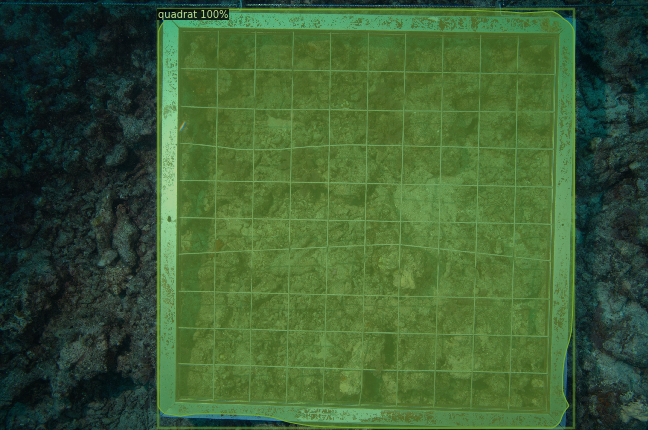

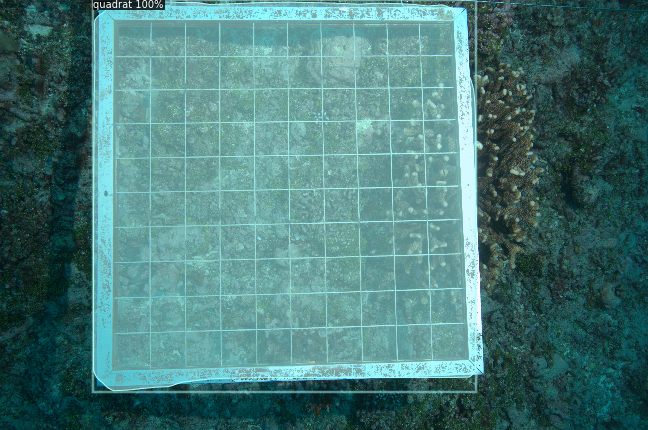

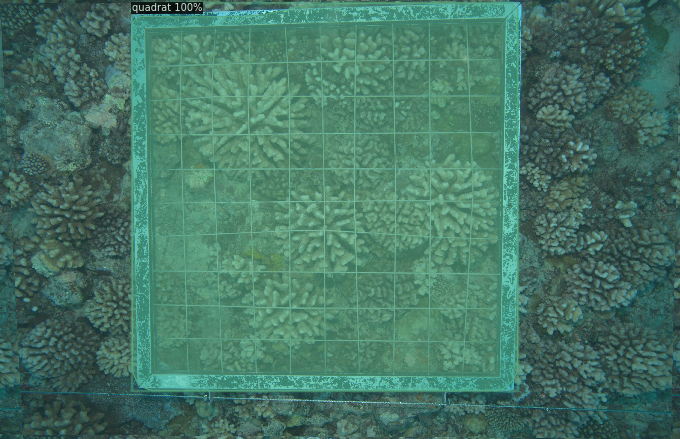

In [ ]:
for d in random.sample(dataset_dicts_test, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  

    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.15
                   )

    # plot predictions
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


## Analysis


### Loss curves

In [ ]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")

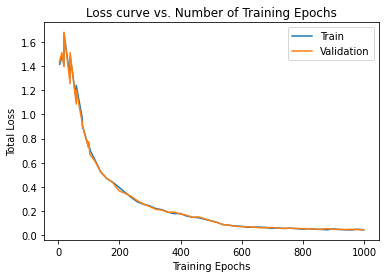

In [ ]:
from matplotlib import pyplot as plt

# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], '-', c="C0", label="Train")
if "total_val_loss" in mdf.columns:
    mdf2 = mdf[~mdf["total_val_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["total_val_loss"], '-', c="C1", label="Validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Total Loss")
plt.show()

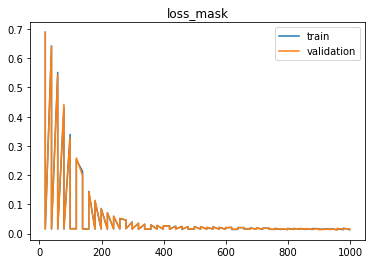

In [ ]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["loss_mask"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_mask"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
if "val_loss_mask" in mdf.columns:
    mdf2 = mdf[~mdf["val_loss_mask"].isna()]
    ax.plot(mdf2["iteration"], mdf2["val_loss_mask"], c="C1", label="validation")
ax.legend()
ax.set_title("loss_mask")
plt.show()

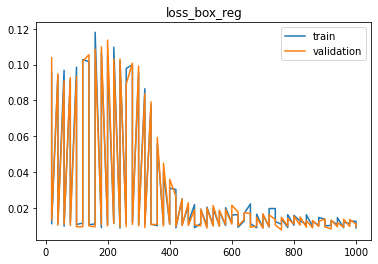

In [ ]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["loss_box_reg"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
if "val_loss_box_reg" in mdf.columns:
    mdf2 = mdf[~mdf["val_loss_box_reg"].isna()]
    ax.plot(mdf2["iteration"], mdf2["val_loss_box_reg"], c="C1", label="validation")
ax.legend()
ax.set_title("loss_box_reg")
plt.show()

